In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness

%matplotlib inline

In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [3]:

os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [ ]:
num_tests = len(meas_columns)
num_rows = int(num_tests/3)+1

fig, ax = plt.subplots(ncols =3 ,nrows = num_rows,figsize = (18,5*num_rows))
fig.patch.set_facecolor("white")
k = 0
for col in [c for c in celldyn if c.startswith("c_b_")]:
    i = int(k/3)
    j = k%3
    plot_data = celldyn.groupby(['afnamejaar'])[col].mean().reset_index()
    plot_data2 = celldyn.groupby(['afnamejaar'])[col].median().reset_index()
    sns.lineplot(data = plot_data,x = 'afnamejaar',y = col,ax = ax[i,j])
    sns.lineplot(data = plot_data2,x = 'afnamejaar',y = col,ax = ax[i,j])
    k+=1
    
plt.savefig("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\mean_median_over_the_years.png",bbox_inches = 'tight')

In [74]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]

celldyn = celldyn[meas_columns+mode_columns+alrt_columns]
celldyn_full = celldyn[celldyn[meas_columns].isna().sum(axis=1)==0] # c_mode_cbc & c_mode_rtc are flagged

D:\Miniconda3\envs\embcelldyn\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='c_b_ht', ylabel='Density'>

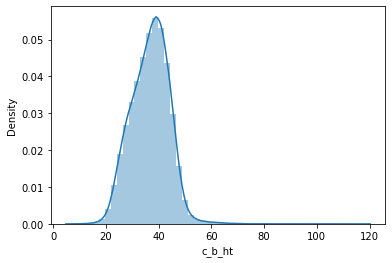

In [75]:
sns.distplot(celldyn_full.c_b_ht)

In [76]:
cut_offs = pd.read_csv("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\CelldynParams.csv",delimiter=";",encoding = 'latin-1')
col_names = cut_offs.columns
cut_offs = pd.DataFrame(np.where(cut_offs == '-',np.nan,cut_offs),columns=col_names)
print(len(celldyn_full))
for c in meas_columns:
    try:
        min_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Min'].iloc[0])
        max_val = float(cut_offs.loc[cut_offs.Kolomnaam == c,'Max'].iloc[0])
        if c == 'c_b_ht':
            min_val*=100
            max_val*=100
        if not pd.isna(min_val):
            celldyn_full = celldyn_full.loc[lambda x:(x[c] <= max_val) & (x[c] >= min_val)]
            print(c, len(celldyn_full))
    except IndexError:
        print(c)



print(len(celldyn_full))

1991634
c_b_wbc 1991630
c_b_neu 1991579
c_b_seg 1991579
c_b_bnd 1991579
c_b_ig 1991579
c_b_lym 1991579
c_b_vlym 1991579
c_b_mon 1991575
c_b_blst 1991575
c_b_eos 1991575
c_b_bas 1991575
c_b_nrbc 1991453
c_b_pneu 1991453
c_b_pseg 1991453
c_b_pbnd 1991453
c_b_pig 1991453
c_b_plym 1991453
c_b_pvlym 1991453
c_b_pmon 1990134
c_b_pblst 1990134
c_b_peos 1990091
c_b_pbas 1990091
c_b_pnrbc 1987533
c_b_rbci 1987533
c_b_rbco 1987435
c_b_hgb_usa 1987387
c_b_mcv 1987371
c_b_rdw 1987361
c_b_pMIC 1987361
c_b_pMAC 1987361
c_b_mch_Usa 1987360
c_b_mchc_usa 1987309
c_b_ht 1975685
c_b_plto 1975637
c_b_plti 1975623
c_b_mpv 1974427
c_b_retc 1973239
c_b_rtcfmn
c_b_rtcfcv
c_b_hb 1973162
c_b_mch 1973162
c_b_mchc 1973162
1973162


### load in data

In [3]:
celldyn_full = pd.read_csv("L:/laupodteam/AIOS/Huibert-Jan/Celldynclustering/Data/data_no_c_s_45.csv")

In [5]:
meas_columns = [c for c in celldyn_full.columns if 'c_b' in c]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [7]:
droplist = ['c_b_wvf', 'c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']
sl_list = ['c_b_bnd', 'c_b_ig', 'c_b_vlym', 'c_b_blst', 'c_b_pblst',
            'c_b_nrbc', 'c_b_pbnd', 'c_b_pig', 'c_b_pvlym', 'c_b_pnrbc']

final_columns = list(set(meas_columns)-set(droplist))


q_scaler = FunctionTransformer(func=lambda x: np.maximum(np.quantile(x,0.001), np.minimum(np.quantile(x, 0.999), x)))
sl_scaler = FunctionTransformer(func=sigmoid_log)
wvf_scaler = FunctionTransformer(func=lambda x: np.maximum(0.90,(np.minimum(1, x))))

transformer_list = [('wvf_scaler', wvf_scaler, ['c_b_wvf']),
                    ('q_scaler', q_scaler, final_columns),
                    ('sl_scaler', sl_scaler, sl_list)]

pre_transformer = ColumnTransformer(transformer_list)


In [ ]:
with open("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\sample_indices.txt",'r') as f:
    samples = [int(x) for x in f.read().split("\n")[:-1]]

In [13]:
sample_df = celldyn_full.sample(50000).reset_index()

reduce_dim = 10


embedder_full = PCA(n_components = reduce_dim)
le_pipe = Pipeline([('scaler_1', pre_transformer),                    
                    ('scaler_2', StandardScaler()),
                    ('embedder', embedder_full)])
le_pipe.fit(sample_df[meas_columns])
transformed_data = le_pipe.transform(sample_df[meas_columns])

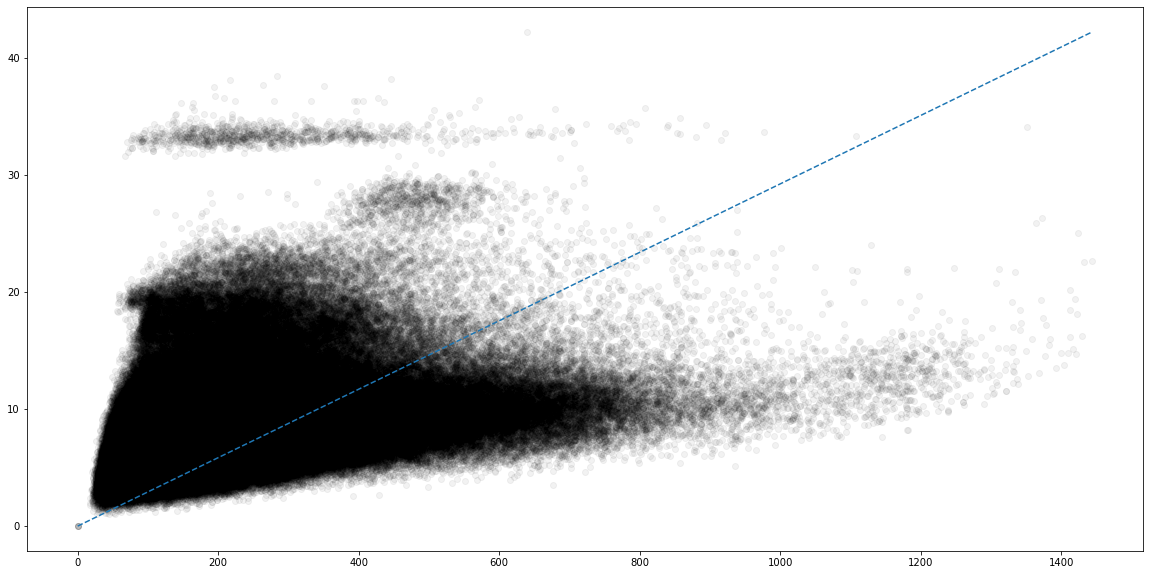

In [15]:
sample_selection = np.random.randint(0,50000,1000)
dist_before = distance.pdist(sample_df.reset_index(drop = True).loc[sample_selection,meas_columns])
dist_after = distance.pdist(transformed_data[sample_selection,:])


plt.figure(figsize = (20,10))
plt.scatter(dist_before,dist_after, alpha = 0.05,c ='black')
mx,my = max(dist_before), max(dist_after)
plt.plot([0,mx],[0,my],ls = "--")

In [16]:
from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

In [17]:
clusterer_embedding = KMeans(n_clusters = 5)
clusterer_embedding.fit(transformed_data)

KMeans(n_clusters=5)

In [18]:
clusterer_org_dat = KMeans(n_clusters = 5)
clusterer_org_dat.fit(StandardScaler().fit_transform(pre_transformer.fit_transform(sample_df[meas_columns])))

KMeans(n_clusters=5)

In [19]:
r_score =rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
ar_score = adjusted_rand_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)
mi_score = adjusted_mutual_info_score(clusterer_org_dat.labels_, clusterer_embedding.labels_)

In [20]:
ch_score1 = calinski_harabasz_score(sample_df[meas_columns], clusterer_org_dat.labels_)
ch_score2 = calinski_harabasz_score(transformed_data, clusterer_embedding.labels_)

db_score1 = davies_bouldin_score(sample_df[meas_columns], clusterer_org_dat.labels_)
db_score2 = davies_bouldin_score(transformed_data, clusterer_embedding.labels_)

In [21]:
dist_preservation_overall = dcor.distance_correlation(dist_before, dist_after)

In [22]:
print("Distance preservation overall", dist_preservation_overall)
#print("Intra-distance trustworthiness", trustworthiness(sample_df[meas_columns], transformed_data))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)

Distance preservation overall 0.39963709966822136
Rand score 0.9883736706734134
Adjusted Rand score 0.9751183794581718
Adjusted MI score 0.9416884482744912
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.5214164406653613
David-Bouldin ratio, higher than 1 means better clustering for embedding 1.6750450335719875


In [24]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(reduce_dim)], index=sample_df.index)
plot_df = plot_df.join(sample_df[mode_columns+alrt_columns])
plot_df['k_means']  = clusterer_embedding.labels_

plot_df['has_alrt'] = np.where(np.sum(plot_df[alrt_columns],axis = 1) >0.5,1,0)
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))

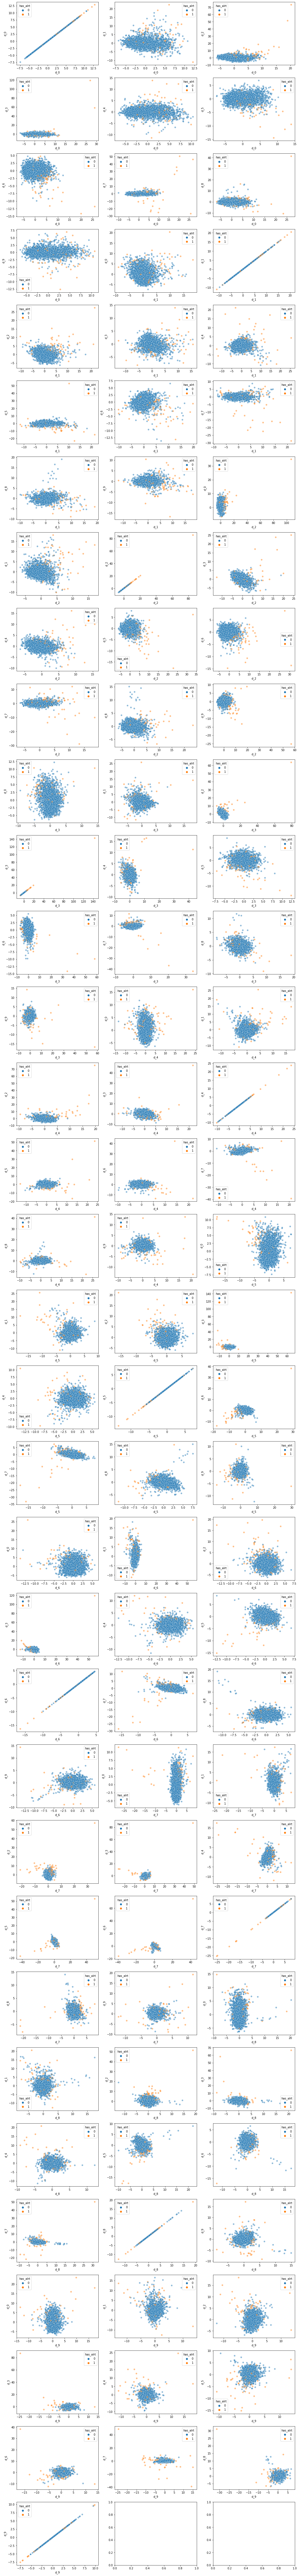

In [25]:
#reduce_dim = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim):
    for kj in range(reduce_dim): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], 
                            hue='has_alrt', alpha=0.5)
        else:
            sns.scatterplot(data=plot_df.sample(2500), x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], 
                            hue='has_alrt', alpha=0.5)
        k += 1